In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
sys.path.append("../")
sys.path.append("../../")

import analysis_utils as tools

In [2]:
methods = ["superspike", "stochasticsuperspike"]
times = ["08-42-20", "08-50-54"]
dataset = "oxford"

nb_epochs = 1500
logging_freq = 500

epochs = [499, 999, 1499]

dt = 1e-3
data_id = 0

In [3]:
path = "../../experiments/spike_train_matching/Runs/{}/dataset=oxford/2024-04-24/{}/"

colors = {
    "stochasticsuperspike": "#EBB400",
    "superspike": "#008ca5"
}
names = {
    "stochasticsuperspike": "stochastic",
    "superspike": "deterministic"
}

data_path = "../../experiments/spike_train_matching/dataset/{}.png".format(dataset)

In [4]:
tot_spk_h = {}
tot_spk_o = {}

for method, time in zip(methods, times):
    print(method, time)
    
    h_seed = []
    o_seed = []
    spk_h, spk_o = tools.get_meas(
        path.format(method, time),
        "spk_hist",
        nb_epochs,
        logging_freq,
        499,
    )
    h_seed.append(spk_h)
    o_seed.append(spk_o)

    h_seed = np.array(h_seed)
    o_seed = np.array(o_seed)

    tot_spk_h[method] = h_seed
    tot_spk_o[method] = o_seed

    print(h_seed.shape)

superspike 08-42-20


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


(1, 1500, 1, 1, 189, 200)
stochasticsuperspike 08-50-54


100%|██████████| 3/3 [00:10<00:00,  3.46s/it]


(1, 1500, 10, 1, 189, 200)


In [5]:
def get_mean_spikes_over_trials(spk, data_id=0):
    return np.mean(spk[:, :, :, data_id, :, :], axis=2)


def get_var_spikes_over_trials(spk, data_id=0):
    return np.var(spk[:, :, :, data_id, :, :], axis=2)


mean_spk_hs = {}
mean_spk_os = {}

for method in methods:
    mean_spk_hs[method] = get_mean_spikes_over_trials(tot_spk_h[method])
    mean_spk_os[method] = get_mean_spikes_over_trials(tot_spk_o[method])

var_spk_hs = {}
var_spk_os = {}

for method in methods:
    var_spk_hs[method] = get_var_spikes_over_trials(tot_spk_h[method])
    var_spk_os[method] = get_var_spikes_over_trials(tot_spk_o[method])

In [6]:
def get_var_div_by_mean_over_trials(mean, var):
    return var / mean


var_div_by_mean_spk_hs = {}
var_div_by_mean_spk_os = {}

total_var_div_by_mean_spk_hs = {}
total_var_div_by_mean_spk_os = {}

for method in methods:
    var_div_by_mean_spk_hs[method] = get_var_div_by_mean_over_trials(
        mean_spk_hs[method], var_spk_hs[method]
    )
    var_div_by_mean_spk_os[method] = get_var_div_by_mean_over_trials(
        mean_spk_os[method], var_spk_os[method]
    )

    total_var_div_by_mean_spk_hs[method] = np.nanmean(
        var_div_by_mean_spk_hs[method], axis=(2, 3)
    )
    total_var_div_by_mean_spk_os[method] = np.nanmean(
        var_div_by_mean_spk_os[method], axis=(2, 3)
    )


/tmp/ipykernel_80170/266798824.py:2: RuntimeWarning: invalid value encountered in divide
  return var / mean


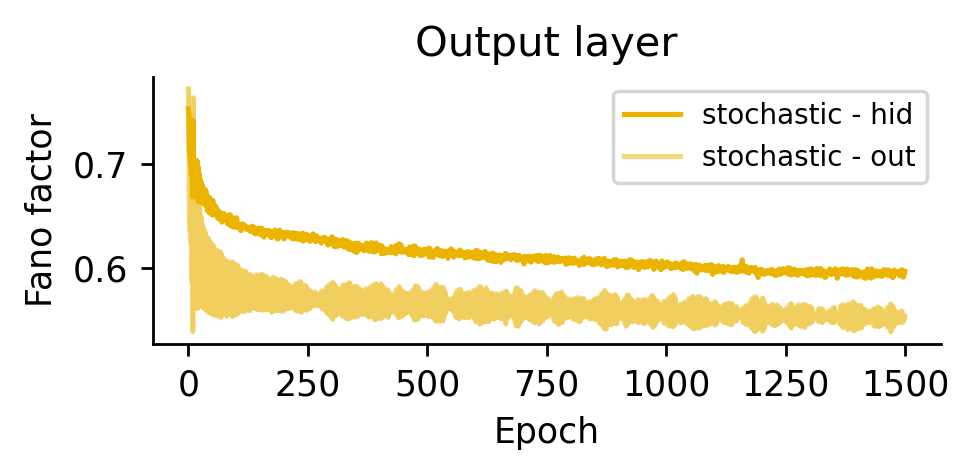

In [7]:
# Plot variance in spike trains over trials divided by mean in spike trains over trials

fig, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=250, sharex=True, sharey=True)
# ax[0].set_ylabel("Variance (over trials) \nin spike trains \ndivided by\nmean (over trials) \nin spike trains ", fontsize=4)
# ax[1].set_ylabel("Variance (over trials) \nin spike trains \ndivided by\nmean (over trials) \nin spike trains ", fontsize=4)

ax.set_ylabel("Fano factor", fontsize=10)

ax.set_title("Hidden layer")
ax.set_title("Output layer")

for method in methods[:2]:
    if method == "superspike":
        continue
    mh = np.nanmean(total_var_div_by_mean_spk_hs[method], axis=0)
    vh = np.nanvar(total_var_div_by_mean_spk_hs[method], axis=0)

    mo = np.nanmean(total_var_div_by_mean_spk_os[method], axis=0)
    vo = np.nanvar(total_var_div_by_mean_spk_os[method], axis=0)

    ax.plot(mh, color=colors[method], alpha=1, label=names[method] + " - hid")
    ax.fill_between(
        np.arange(len(mh)), mh - vh, mh + vh, color=colors[method], alpha=0.25
    )
    ax.plot(mo, color=colors[method], alpha=0.5, label=names[method]+ " - out")
    ax.fill_between(
        np.arange(len(mo)), mo - vo, mo + vo, color=colors[method], alpha=0.25
    )

ax.set_xlabel("Epoch")
ax.set_xlabel("Epoch")

ax.legend(fontsize=8)
sns.despine()
plt.tight_layout()

In [8]:
def get_firing_rates(spk, dt=1e-3, data_id=0):
    duration = spk.shape[-2] * dt
    return np.sum(spk, axis=-2) / duration


fr_spk_hs = {}
fr_spk_os = {}

for method in methods:
    fr_spk_hs[method] = get_firing_rates(tot_spk_h[method], dt, data_id)
    fr_spk_os[method] = get_firing_rates(tot_spk_o[method], dt, data_id)


In [9]:
mean_fr_spk_hs = {}
mean_fr_spk_os = {}

var_fr_spk_hs = {}
var_fr_spk_os = {}

for method in methods:
    mean_fr_spk_hs[method] = np.mean(fr_spk_hs[method], axis=2)
    mean_fr_spk_os[method] = np.mean(fr_spk_os[method], axis=2)

    var_fr_spk_hs[method] = np.var(fr_spk_hs[method], axis=2)
    var_fr_spk_os[method] = np.var(fr_spk_os[method], axis=2)

In [10]:
pop_fr_spk_hs = {}
pop_fr_spk_os = {}

for method in methods:
    pop_fr_spk_hs[method] = np.mean(fr_spk_hs[method], axis=-1)
    pop_fr_spk_os[method] = np.mean(fr_spk_os[method], axis=-1)

In [11]:
mean_pop_fr_spk_hs = {}
mean_pop_fr_spk_os = {}

var_pop_fr_spk_hs = {}
var_pop_fr_spk_os = {}

for method in methods:
    mean_pop_fr_spk_hs[method] = np.mean(pop_fr_spk_hs[method], axis=2)
    mean_pop_fr_spk_os[method] = np.mean(pop_fr_spk_os[method], axis=2)

    var_pop_fr_spk_hs[method] = np.var(pop_fr_spk_hs[method], axis=2)
    var_pop_fr_spk_os[method] = np.var(pop_fr_spk_os[method], axis=2)


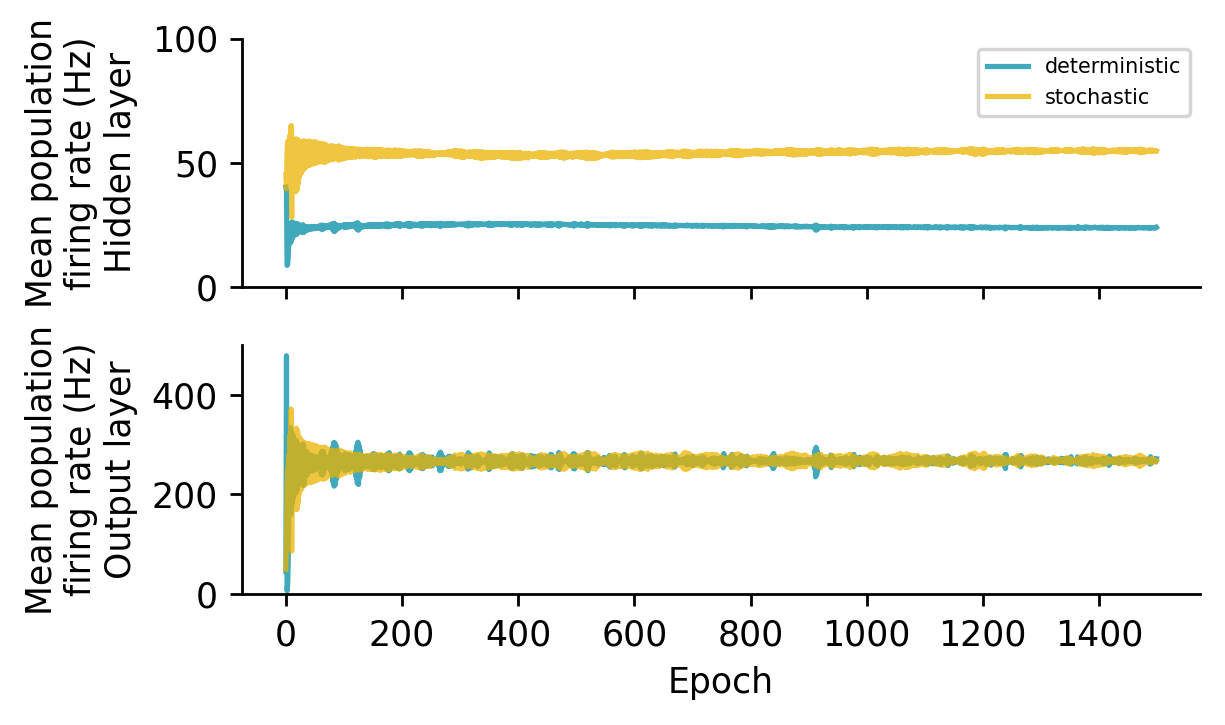

In [12]:
fig, ax = plt.subplots(2,1, figsize=(5,3), dpi=250, sharex=True, sharey=False)

for method in methods:
    mh = np.mean(mean_pop_fr_spk_hs[method], axis=0).squeeze()
    vh = np.var(mean_pop_fr_spk_hs[method], axis=0).squeeze()

    ax[0].plot(mh, color=colors[method], alpha=0.75, label=names[method])
    ax[0].fill_between(np.arange(len(mh)), mh-vh, mh+vh, color=colors[method], alpha=0.25, edgecolor=None)

    mo = np.mean(mean_pop_fr_spk_os[method], axis=0).squeeze()
    vo = np.var(mean_pop_fr_spk_os[method], axis=0).squeeze()

    ax[1].plot(mo, color=colors[method], alpha=0.75, label=names[method])
    ax[1].fill_between(np.arange(len(mo)), mo-vo, mo+vo, color=colors[method], alpha=0.25, edgecolor=None)

ax[1].set_xlabel("Epoch")
ax[0].set_ylabel("Mean population\nfiring rate (Hz)\nHidden layer")
ax[1].set_ylabel("Mean population\nfiring rate (Hz)\nOutput layer")

ax[0].set_ylim(0, 100)
ax[1].set_ylim(0, 500)

ax[0].legend(fontsize=6)
sns.despine()
plt.tight_layout()
